In [1]:
!pip install split-folders matplotlib opencv-python spic

In [2]:
import numpy as np
import cv2 as cv
import os
import splitfolders

# image processing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img


In [4]:
splitfolders.ratio("Downloads/aug_msid/aug_mkp copy", output="Downloads/aug_msidDN121/aug_mkp copy/EFNetB5_TrueFalse", seed=1337, ratio=(0.8, 0.1, 0.1), group_prefix=None, move=False)

Copying files: 5680 files [01:08, 83.48 files/s] 


In [5]:
datagen = ImageDataGenerator(rescale=1.0/255)

In [6]:
class_names = ['Chickenpox','Measles','Monkeypox','Normal']

In [7]:
train_generator = datagen.flow_from_directory(
    directory="Downloads/aug_msidDN121/aug_mkp copy/EFNetB5_TrueFalse/train",
    classes = class_names,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
)

Found 4543 images belonging to 4 classes.


In [8]:
valid_generator = datagen.flow_from_directory(
    directory="Downloads/aug_msidDN121/aug_mkp copy/EFNetB5_TrueFalse/val",
    classes = class_names,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

Found 565 images belonging to 4 classes.


In [9]:
test_generator = datagen.flow_from_directory(
    directory="Downloads/aug_msidDN121/aug_mkp copy/EFNetB5_TrueFalse/test/",
    classes = class_names,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

Found 572 images belonging to 4 classes.


In [10]:
import tensorflow as tf

EFNetB5 = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    classes=4,
    classifier_activation="softmax"
)
#print(EFNetB5.summary())


In [13]:
split_point = len(EFNetB5.layers) // 2
for layer in (EFNetB5.layers)[:split_point]:
    layer.trainable = False

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

EFNetB5_model = Sequential()
EFNetB5_model.add(EFNetB5)
EFNetB5_model.add(Flatten())
EFNetB5_model.add(Dense(256, activation='relu'))
EFNetB5_model.add(Dense(4, activation='softmax'))

In [15]:
EFNetB5_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional  (None, 7, 7, 2048)        28513527  
 )                                                               
                                                                 
 module_wrapper (ModuleWrap  (None, 100352)            0         
 per)                                                            
                                                                 
 module_wrapper_1 (ModuleWr  (None, 256)               25690368  
 apper)                                                          
                                                                 
 module_wrapper_2 (ModuleWr  (None, 4)                 1028      
 apper)                                                          
                                                                 
Total params: 54204923 (206.78 MB)
Trainable params: 256

In [16]:
EFNetB5_model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [17]:
epochs=15
history = EFNetB5_model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs
)

Epoch 1/15
142/142 [==============================] - 1399s 9s/step - loss: 1.9472 - accuracy: 0.2648 - val_loss: 1.6188 - val_accuracy: 0.2867
Epoch 2/15
142/142 [==============================] - 1286s 9s/step - loss: 1.6487 - accuracy: 0.3011 - val_loss: 1.5056 - val_accuracy: 0.3292
Epoch 3/15
142/142 [==============================] - 1279s 9s/step - loss: 1.5149 - accuracy: 0.3227 - val_loss: 1.9136 - val_accuracy: 0.3257
Epoch 4/15
142/142 [==============================] - 1266s 9s/step - loss: 1.6022 - accuracy: 0.3079 - val_loss: 1.8876 - val_accuracy: 0.2743
Epoch 5/15
142/142 [==============================] - 1266s 9s/step - loss: 1.5493 - accuracy: 0.3209 - val_loss: 1.9879 - val_accuracy: 0.2708
Epoch 6/15
142/142 [==============================] - 1270s 9s/step - loss: 1.4488 - accuracy: 0.3372 - val_loss: 1.3035 - val_accuracy: 0.3540
Epoch 7/15
142/142 [==============================] - 1282s 9s/step - loss: 1.4977 - accuracy: 0.3311 - val_loss: 1.3883 - val_accuracy:

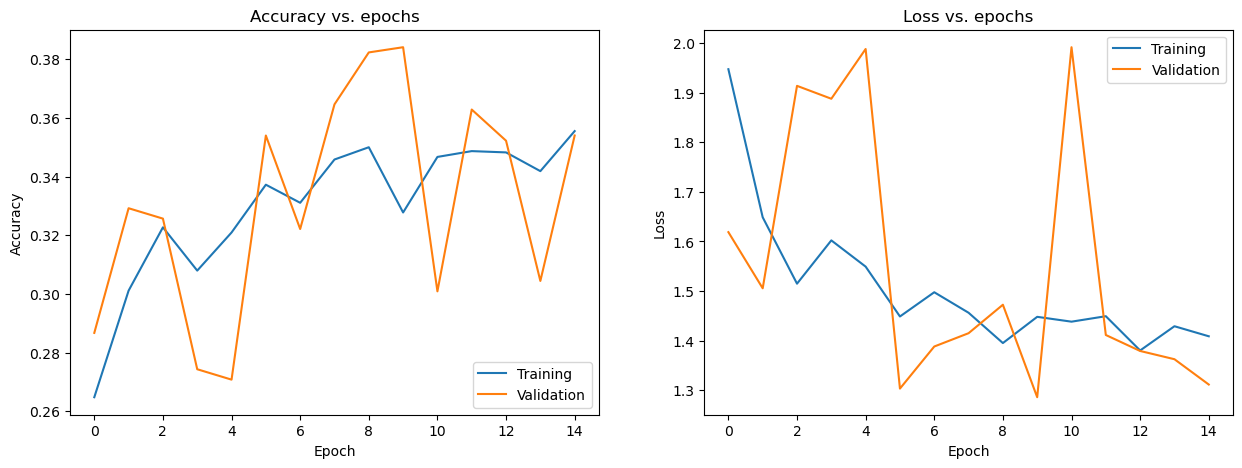

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [21]:
#Evaluate the model
test_loss, test_acc = EFNetB5_model.evaluate(test_generator)
print("The test loss is: ", test_loss)
print("The best accuracy is: ", test_acc)

18/18 [==============================] - 219s 12s/step - loss: 1.3389 - accuracy: 0.3322
The test loss is:  1.3389428853988647
The best accuracy is:  0.3321678340435028


In [ ]:
EFNetB5_model.save('my_EFNetB5_TF_model')

18/18 [==============================] - 231s 12s/step
Confusion Matrix:
[[ 12   4 103  23]
 [ 19   4  99  21]
 [ 28   5  88  21]
 [ 14   8  98  25]]

Classification Report:
              precision    recall  f1-score   support

  Chickenpox       0.16      0.08      0.11       142
     Measles       0.19      0.03      0.05       143
   Monkeypox       0.23      0.62      0.33       142
      Normal       0.28      0.17      0.21       145

    accuracy                           0.23       572
   macro avg       0.21      0.23      0.18       572
weighted avg       0.22      0.23      0.18       572



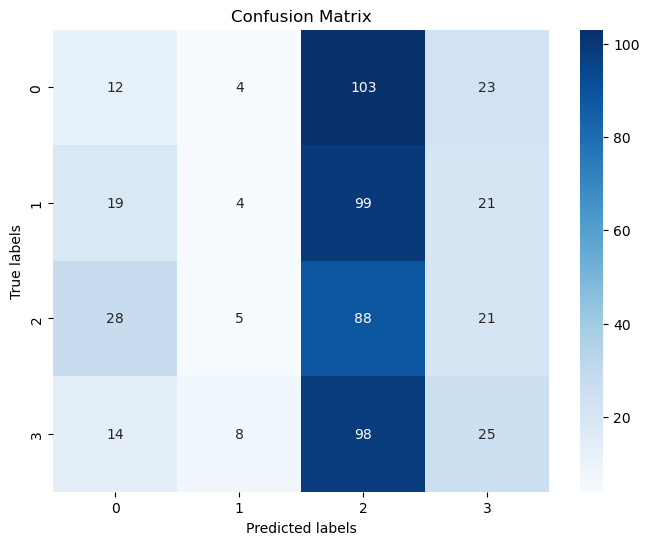

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions on the test dataset
predictions = EFNetB5_model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes

# Calculate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Calculate precision, recall, and F1-score
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print confusion matrix and classification report
print("Confusion Matrix:")
print(confusion)
print("\nClassification Report:")
print(report)



from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()